# Resources and credit:
- SSDD data download: https://github.com/TianwenZhang0825/LS-SSDD-v1.0-OPEN
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html

# Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [5]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
exit(0)

     |████████████████████████████████| 276kB 20.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=8b44888fedc38b4cb1962f1f4dd3e63cd180334141ac2252d3278df660951659
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [6]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 718kB/s 
     |████████████████████████████████| 2.2MB 29.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20210115-cp36-none-any.whl size=40892 sha256=5d6de48164021241f34fd3474a8bd820caf03e4e46a9bfb3cd82901203fab0b4
  Stored in directory: /root/.cache/pip/wheels/cc/0f/bc/fb742771f4a877f1211dd6ed36283b0db9c0ceb2b409b4a039
  Created wheel for iopath: filename=iopath-0.1.3-cp36-none-any.whl size=11169 sha256=63bb9d537df063e8c58334d03184a29af2597d0418c67dcefaca27f1243c8b12
  Stored in directory: /root/.cache/pip/wheels/a9/1d/55/94a55e032409ac7617f9cbb88a0fa2cf4e7208806c29730804
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.

# Registration

In [6]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [7]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [8]:
# Global paths
datasets = '/content/drive/MyDrive/SSDD/datasets/'
pre = 'ssdd_'
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from detectron2.structures import BoxMode
# Register
for d in ["train", "test", "test_offshore", "test_inshore"]:
    DatasetCatalog.register(pre + d, lambda d=d: get_dict(d))
    MetadataCatalog.get(pre + d).set(thing_classes=["ship"])

AssertionError: ignored

In [ ]:
# Instances of metadata
train_metadata = MetadataCatalog.get(pre + 'train')
test_metadata = MetadataCatalog.get(pre + 'test')

# Training
*Change Runtime to GPU before running*

In [11]:
%cd /content/drive/MyDrive/SSDD/
output = '/content/drive/MyDrive/SSDD/'
model_name = "./ModelOutput/faster_rcnn_R_50_FPN_3x_1_22_2021"

/content/drive/MyDrive/SSDD


In [12]:
from detectron2.engine import DefaultTrainer
# model zoo - https://github.com/facebookresearch/detectron2/tree/master/configs/COCO-Detection
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (pre + "train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False # allows training examples without annotations
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

In [13]:
cfg.OUTPUT_DIR = model_name
cfg.OUTPUT_DIR

'./ModelOutput/faster_rcnn_R_50_FPN_3x_1_22_2021'

In [17]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/23 00:53:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:07, 23.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[01/23 00:53:20 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[01/23 00:53:30 d2.utils.events]:  eta: 0:02:13  iter: 19  total_loss: 0.8322  loss_cls: 0.7567  loss_box_reg: 0.0002188  loss_rpn_cls: 0.003879  loss_rpn_loc: 0.006506  time: 0.4933  data_time: 0.3503  lr: 4.9953e-06  max_mem: 1829M
[01/23 00:53:40 d2.utils.events]:  eta: 0:02:01  iter: 39  total_loss: 0.6196  loss_cls: 0.6133  loss_box_reg: 0  loss_rpn_cls: 0.0003523  loss_rpn_loc: 0  time: 0.4742  data_time: 0.2988  lr: 9.9902e-06  max_mem: 1829M
[01/23 00:53:49 d2.utils.events]:  eta: 0:01:50  iter: 59  total_loss: 0.4107  loss_cls: 0.4009  loss_box_reg: 0  loss_rpn_cls: 0.000146  loss_rpn_loc: 0  time: 0.4622  data_time: 0.2743  lr: 1.4985e-05  max_mem: 1829M
[01/23 00:53:57 d2.utils.events]:  eta: 0:01:38  iter: 79  total_loss: 0.2456  loss_cls: 0.2456  loss_box_reg: 0  loss_rpn_cls: 0.0003086  loss_rpn_loc: 0  time: 0.4544  data_time: 0.2657  lr: 1.998e-05  max_mem: 1829M
[01/23 00:54:06 d2.utils.events]:  eta: 0:01:30  iter: 99  total_loss: 0.148  loss_cls: 0.147  loss_box_reg:

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir faster_rcnn_R_50_FPN_3x_1_22_2021

# Evaluation

In [18]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

## Visualization

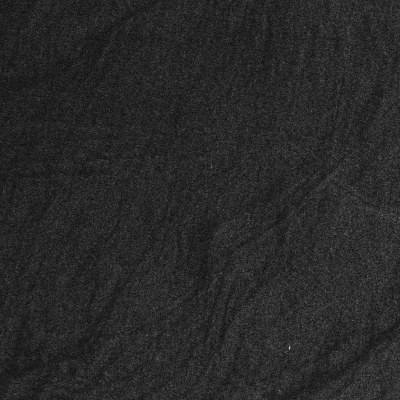

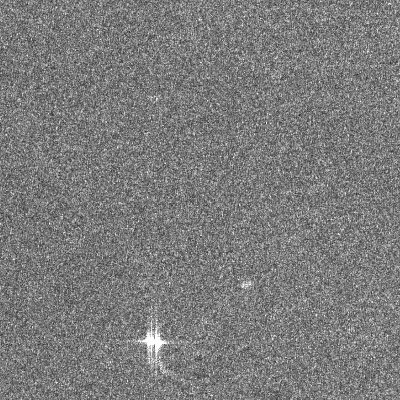

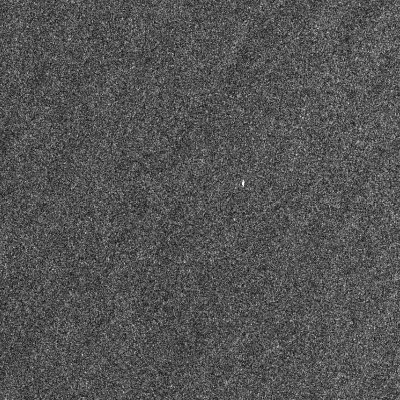

In [22]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dict("train")

# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['annotations'] != []:
    dataset_dicts_anns.append(i)

random.seed(6)
for d in random.sample(dataset_dicts_anns, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata, 
                   scale=0.5
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

## Prediction

In [19]:
val = './datasets/test/'

In [20]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator('ssdd_test_offshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_offshore')
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[01/23 00:55:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/23 00:55:43 d2.data.common]: Serializing 2234 elements to byte tensors and concatenating them all ...
[01/23 00:55:43 d2.data.common]: Serialized dataset takes 0.41 MiB
[01/23 00:55:43 d2.evaluation.evaluator]: Start inference on 2234 images
[01/23 00:55:46 d2.evaluation.evaluator]: Inference done 11/2234. 0.0770 s / img. ETA=0:09:24
[01/23 00:55:51 d2.evaluation.evaluator]: Inference done 36/2234. 0.0779 s / img. ETA=0:07:43
[01/23 00:55:56 d2.evaluation.evaluator]: Inference done 59/2234. 0.0785 s / img. ETA=0:07:47
[01/23 00:56:01 d2.evaluation.evaluator]: Inference done 83/2234. 0.0787 s / img. ETA=0:07:41
[01/23 00:56:06 d2.evaluation.evaluator]: Inference done 107/2234. 0.0789 s / img. ETA=0:07:37
[01/23 00:56:11 d2.evaluation.evaluator]: Inference done 133/2234. 0.0789 s / img. ETA=0:07:23
[01/23 00